In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

import sys
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline")

import datapipe
import datapipe.denoising.wavelets_mrfilter as mrfilter

sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils")
import common_functions as common

from datapipe.io import images
from datapipe.io import geometry_converter
import datapipe.io.montecarlo_calibration_astri as mc_calibration

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/astropy/utils/introspection.py:153: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import parse_version
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


In [2]:
tel_id = 18
source = hessio_event_source("/Users/jdecock/data/astri_mini_array/proton/run10001.simtel.gz", allowed_tels=[tel_id])

In [3]:
for ev in source:
    if tel_id in ev.dl0.tel:
        print(ev.dl0.tel[tel_id+1].adc_sums[1])

In [4]:
#print(ev)

[ 971.  971.  971. ...,  971.  971.  971.]
[ 961.  961.  961. ...,  961.  961.  961.]
[ 0.0160785   0.01635359  0.0158726  ...,  0.01671376  0.01579875
  0.01578693]
[ 0.64334589  0.65435308  0.63510722 ...,  0.66876459  0.63215226
  0.63167953]
[1114 1082 1122 ..., 1153 1032  992]
[964 964 964 ..., 965 962 961]
[0 0 0 ..., 0 0 0]


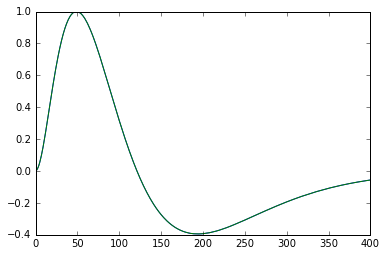

In [5]:
# Pedestal
print(ev.mc.tel[tel_id].pedestal[0])
print(ev.mc.tel[tel_id].pedestal[1])

# Gain
print(ev.mc.tel[tel_id].dc_to_pe[0])
print(ev.mc.tel[tel_id].dc_to_pe[1])

# ADC sums
print(ev.r0.tel[tel_id].adc_sums[0])
print(ev.r0.tel[tel_id].adc_sums[1])

print(ev.mc.tel[tel_id].photo_electron_image)

ev.mc.tel[tel_id].reference_pulse_shape.shape

plt.plot(ev.mc.tel[tel_id].reference_pulse_shape[0])
plt.plot(ev.mc.tel[tel_id].reference_pulse_shape[1])

# TODO!!!
#help(pyhessio)
#pedestal, gains = get_mc_calibration_data(tel_id)
#print("pedestal:", pedestal)
#print("gains:", gains)

In [6]:
# GET IMAGES ##############################################

pe_image = ev.mc.tel[tel_id].photo_electron_image   # 1D np array
uncalibrated_image = ev.r0.tel[tel_id].adc_sums     # ctapipe 0.4.0
pedestal = ev.mc.tel[tel_id].pedestal
gain = ev.mc.tel[tel_id].dc_to_pe
pixel_pos = ev.inst.pixel_pos[tel_id]

# calibrating
calibrated_image = mc_calibration.apply_mc_calibration(uncalibrated_image, pedestal, gain)

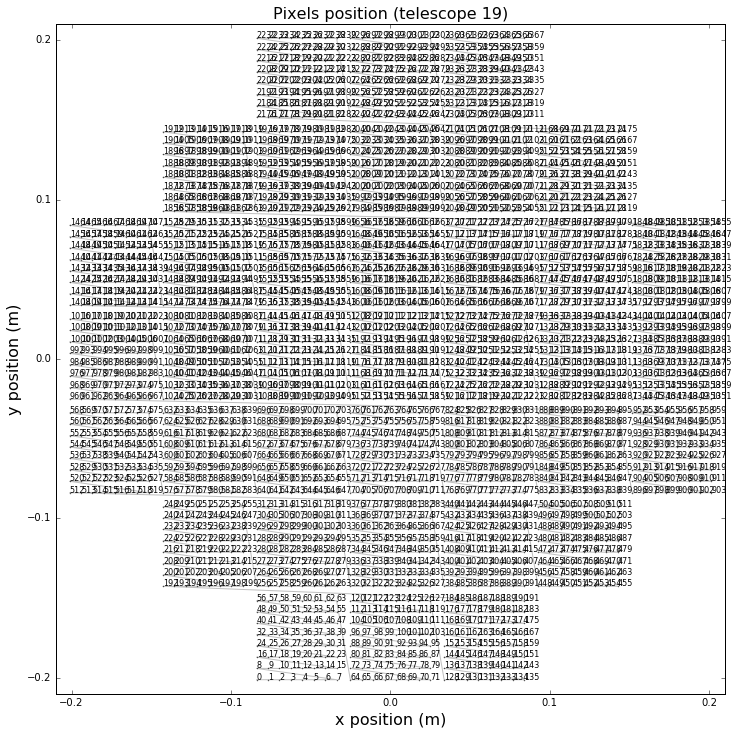

In [7]:
# %load ~/git/pub/jdhp-sap/snippets/ctapipe/plot_pixels_index.py
#!/usr/bin/env python3

"""
Display the pixel layout of the givent telescope as defined in a given simtel file.
"""

(pos_x_list, pos_y_list) = pixel_pos
pos_x_list = [float(pos.value) for pos in pos_x_list]
pos_y_list = [float(pos.value) for pos in pos_y_list]

assert len(pos_x_list) == len(pos_y_list)

# PLOT ####################################################################

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

# Scatter method ##################

ax.scatter(pos_x_list,    # x
           pos_y_list,    # y
           s=0.2,         # radius
           c="black",     # color
           alpha=0.75)

ax.plot(pos_x_list,    # x
        pos_y_list,    # y
        "k-",
        alpha=0.25)

for pixel_index in range(len(pos_x_list)):
    ax.text(pos_x_list[pixel_index], pos_y_list[pixel_index], str(pixel_index), fontsize=8)

ax.set_title("Pixels position (telescope {})".format(tel_id), fontsize=16)

ax.set_xlabel("x position (m)", fontsize=16)
ax.set_ylabel("y position (m)", fontsize=16)

ax.set_xlim(-0.21, 0.21)
ax.set_ylim(-0.21, 0.21)

plt.show()

### Crop image

In [8]:
# cropping ADC image
cropped_adc_sums = geometry_converter.astry_to_3d_array(uncalibrated_image)

# cropping PE image
cropped_pe_img = geometry_converter.astry_to_2d_array(pe_image)

# cropping calibrated image
cropped_img = geometry_converter.astry_to_2d_array(calibrated_image)

# cropping pedestal and gain
cropped_pedestal = geometry_converter.astry_to_3d_array(pedestal)
cropped_gains = geometry_converter.astry_to_3d_array(gain)

# cropping pixel positions
cropped_pixel_pos = geometry_converter.astry_to_3d_array(pixel_pos)

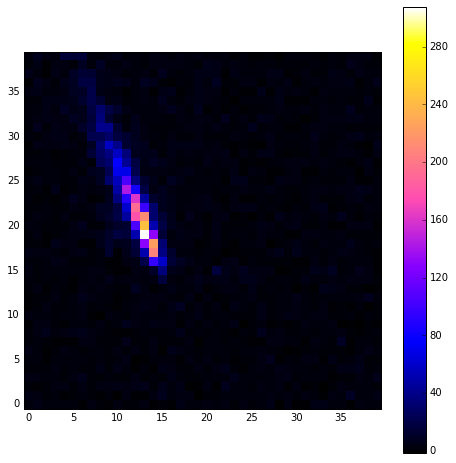

In [9]:
images.plot(cropped_img)

### Don't crop image

In [10]:
# cropping ADC image
not_cropped_adc_sums = geometry_converter.astry_to_3d_array(uncalibrated_image, crop=False)

# cropping PE image
not_cropped_pe_img = geometry_converter.astry_to_2d_array(pe_image, crop=False)

# cropping calibrated image
not_cropped_img = geometry_converter.astry_to_2d_array(calibrated_image, crop=False)

# cropping pedestal and gain
not_cropped_pedestal = geometry_converter.astry_to_3d_array(pedestal, crop=False)
not_cropped_gains = geometry_converter.astry_to_3d_array(gain, crop=False)

# cropping pixel positions
not_cropped_pixel_pos = geometry_converter.astry_to_3d_array(pixel_pos, crop=False)

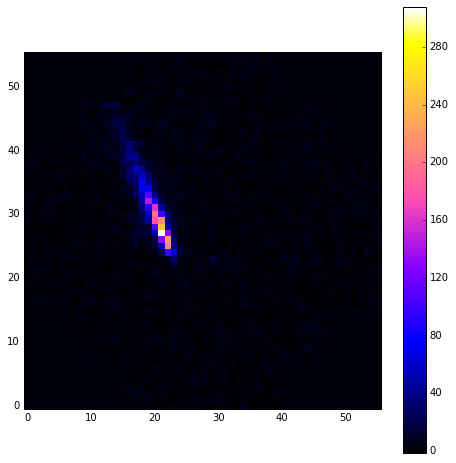

In [11]:
images.plot(not_cropped_img)